# Training an LSTM Classifier to Predict Stock Direction

This notebook focuses on training an LSTM classifier to predict the direction of Tesla's stock price (up or down). The model is trained and evaluated to predict future price movements, with a focus on improving accuracy, particularly for downturn predictions.

## Install and Import libraries

In [ ]:
%pip install yfinance matplotlib scikit-learn tensorflow seaborn

In [10]:
# Standard libraries
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# TensorFlow/Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Plotting style
plt.style.use('dark_background')


## Data

### Define List of Tech Stocks

In [11]:
tickers = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'TSLA', 'AMD',
    'INTC', 'CRM', 'ADBE', 'ORCL', 'SHOP', 'UBER', 'LYFT',
    'NFLX', 'TWLO', 'SNOW', 'PLTR'
]

### Sequence Creation Function

In [12]:
def create_sequences(data, target, sequence_length=10):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(target[i + sequence_length])
    return np.array(X), np.array(y)


### Download and Preprocess Data for All Stocks

In [13]:
sequence_length = 10
all_X, all_y = [], []

for ticker in tickers:
    df = yf.download(ticker, start='2000-01-01', end='2024-12-31', interval='1wk')[['Open', 'High', 'Low', 'Close', 'Volume']]
    df.dropna(inplace=True)

    # Binary target: price will go up next week
    df['Target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)
    df.dropna(inplace=True)

    # Feature scaling
    scaler = MinMaxScaler()
    features = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close', 'Volume']])

    X, y = create_sequences(features, df['Target'].values, sequence_length=sequence_length)
    all_X.append(X)
    all_y.append(y)

# Combine all stocks' sequences
X_all = np.concatenate(all_X, axis=0)
y_all = np.concatenate(all_y, axis=0)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

### Train/Test Split

In [14]:
# First split: train vs (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_all, y_all, test_size=0.3, random_state=42, shuffle=True
)

# Second split: validation vs test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True
)


## Train LSTM Model

### Build LSTM Model

In [22]:
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),  # Increased units in the first LSTM layer
    Dropout(0.3),  # Increased dropout rate to prevent overfitting
    LSTM(100, return_sequences=True),  # Added another LSTM layer with more units
    Dropout(0.3),  # Increased dropout rate
    LSTM(100),  # Added another LSTM layer
    Dropout(0.3),  # Increased dropout rate
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

c:\Users\Brian\OneDrive - University of Witwatersrand\Desktop\off_the_grid\tutorials\technical_analysis\LSTM_stock_price_direction_classifier\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 10, 100)        │        42,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 10, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 203,301 (794.14 KB)

 Trainable params: 203,301 (794.14 KB)

 Non-trainable params: 0 (0.00 B)

### Train the Model

In [23]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.5430 - loss: 0.6912 - val_accuracy: 0.5234 - val_loss: 0.6940
Epoch 2/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5430 - loss: 0.6903 - val_accuracy: 0.5234 - val_loss: 0.6922
Epoch 3/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5370 - loss: 0.6905 - val_accuracy: 0.5234 - val_loss: 0.6924
Epoch 4/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5387 - loss: 0.6907 - val_accuracy: 0.5234 - val_loss: 0.6930
Epoch 5/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.5445 - loss: 0.6894 - val_accuracy: 0.5234 - val_loss: 0.6920
Epoch 6/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.5344 - loss: 0.6912 - val_accuracy: 0.5234 - val_loss: 0.6934
Epoch 7/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.5428 - loss: 0.6897 - val_accuracy: 0.5234 - val_loss: 0.6920
Epoch 8/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.5368 - loss: 0.6907 - 

## Evaluation

### Evaluate Model Accuracy

In [24]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5305 - loss: 0.6918
Test Accuracy: 0.5241


### Plot Training History

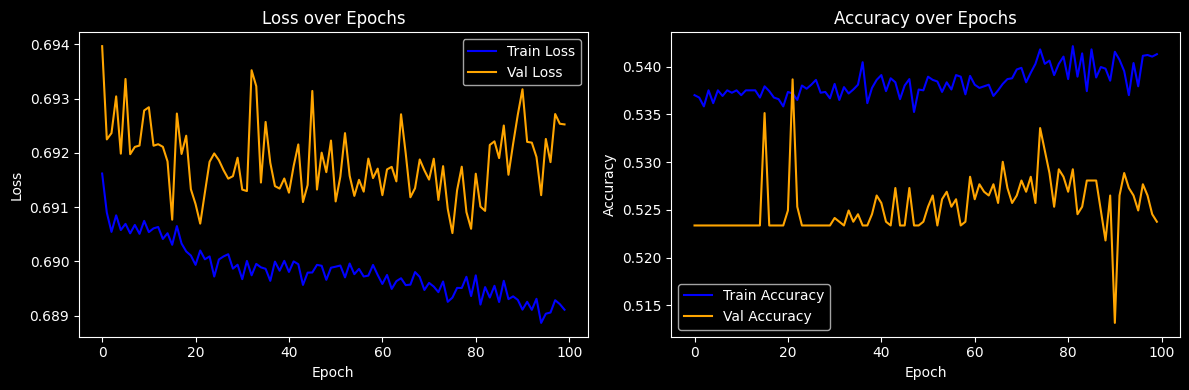

In [25]:
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('loss_accuracy.png')
plt.show()

### Classification Report

In [26]:
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = y_test.flatten()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Down (0)', 'Up (1)']))

80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
Classification Report:
              precision    recall  f1-score   support

    Down (0)       0.44      0.07      0.12      1189
      Up (1)       0.53      0.92      0.67      1358

    accuracy                           0.52      2547
   macro avg       0.49      0.50      0.40      2547
weighted avg       0.49      0.52      0.42      2547



### Confusion Matrix

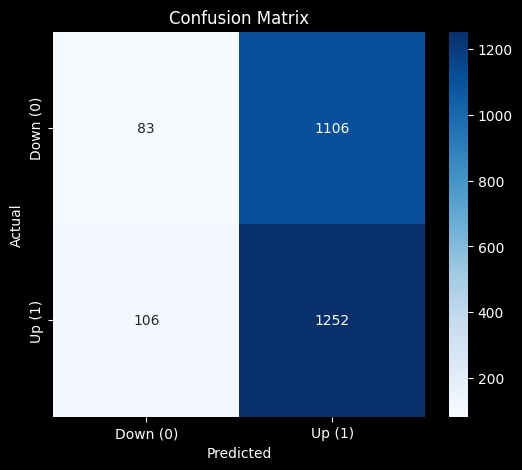

In [27]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Down (0)', 'Up (1)'], yticklabels=['Down (0)', 'Up (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

### Visualize Predictions vs Actual (First 100 Samples)

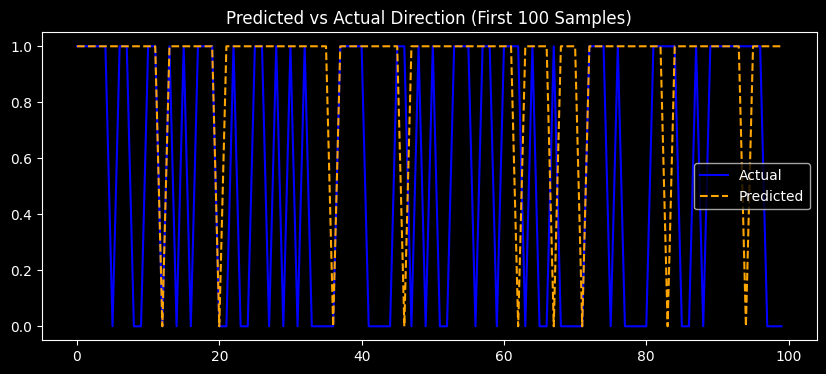

In [28]:
plt.figure(figsize=(10, 4))
plt.plot(y_test[:100], label='Actual', color='blue')
plt.plot(y_pred[:100], label='Predicted', color='orange', linestyle='--')
plt.legend()
plt.title('Predicted vs Actual Direction (First 100 Samples)')
plt.savefig('predicted_vs_actual.png')
plt.show()